In [1]:
# data science imports
import pandas as pd
import matplotlib.pyplot as plt

# census data imports
import censusdis.data as ced
import censusdis.maps as cem
from censusdis import states
from censusdis import datasets

# other imports
import os

In [2]:
# Load the API key
with open("../census_api_key.txt", "r") as f:
    CENSUS_API_KEY = f.read().strip()

# print(CENSUS_API_KEY)

In [3]:
# max cell size
pd.set_option("display.max_colwidth", 100)
# max length
pd.set_option("display.max_rows", 176)

## Exploring Alternative Census Datasets

In [4]:
# look at all the datasets
(
    # show all, then filter for cps
    ced.variables.all_data_sets()
    .loc[
        lambda x: x["DATASET"].str.contains("cps", case=False)
    ]
    ["DATASET"]
    .unique()
)

array(['cps/basic/apr', 'cps/basic/aug', 'cps/basic/dec', 'cps/basic/feb',
       'cps/basic/jan', 'cps/basic/jul', 'cps/basic/jun', 'cps/basic/mar',
       'cps/basic/may', 'cps/basic/nov', 'cps/basic/oct', 'cps/basic/sep',
       'cps/asec/mar', 'cps/internet/nov', 'cps/school/oct',
       'cps/voting/nov', 'cps/contworker/feb', 'cps/foodsec/apr',
       'cps/marital/jun', 'cps/race/may', 'cps/vets/aug', 'cps/dwjt/feb',
       'cps/internet/oct', 'cps/vets/sep', 'cps/worksched/may',
       'cps/fertility/jun', 'cps/foodsec/aug', 'cps/internet/dec',
       'cps/foodsec/sep', 'cps/internet/aug', 'cps/foodsec/dec',
       'cps/internet/sep', 'cps/dwjt/jan', 'cps/library/oct',
       'cps/pubarts/aug', 'cps/volunteer/sep', 'cps/tobacco/aug',
       'cps/tobacco/may', 'cps/tobacco/jan', 'cps/civic/nov',
       'cps/immigration/aug', 'cps/unbank/jan', 'cps/vets/jul',
       'cps/internet/jul', 'cps/unbank/jun', 'cps/disability/may',
       'cps/pubarts/jul', 'cps/arts/feb', 'cps/tobacco/ju

In [5]:
# demonstrate that there are no groups
DATASET = "cps/asec/mar"
YEAR = 2024

groups = ced.variables.all_groups(DATASET, YEAR)
groups.head()

,DATASET,YEAR,GROUP,DESCRIPTION


In [6]:
# see variables with weight recs
cps_vars = ced.variables.all_variables(DATASET, YEAR, None)
cps_vars.head()

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2024,cps/asec/mar,N/A,ACTC_CRD,Aditional Child Tax Credit,MARSUPWT,NaN
1,2024,cps/asec/mar,N/A,AGE1,"Demographics, Age recode, persons 15+ years",MARSUPWT,"{'9': '40 to 44 years', '6': '25 to 29 years', '5': '22 to 24 years', '4': '20 and 21 years', '8..."
2,2024,cps/asec/mar,N/A,AGI,Federal adjusted gross income,MARSUPWT,NaN
3,2024,cps/asec/mar,N/A,ANN_VAL,"Retirement income, annuities amount",MARSUPWT,NaN
4,2024,cps/asec/mar,N/A,ANN_YN,"Retirement income, annuities, y/n",MARSUPWT,"{'2': 'No', '0': 'Niu', '1': 'Yes'}"


In [7]:
# demonstrate that it's a lot
len(cps_vars)

1048

## Working with Current Population Survey (CPS) Data

In [8]:
# set your download variables
variables = {
    "FPOVCUT": "cutoff",
    "MARSUPWT": "person_weight",
    "FTOTVAL": "family_income",
    "FSUP_WGT": "family_weight",
    "A_AGE": "age",
    "FAMLIS": "family_status",
}

In [9]:
# use isin to check the variables
cps_vars[ cps_vars["VARIABLE"].isin(variables.keys()) ]
# the variables table contains the suggested weight 
# More info at CPS docs: https://www2.census.gov/programs-surveys/cps/techdocs/cpsmar24.pdf

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
21,2024,cps/asec/mar,N/A,A_AGE,"Demographics, Age",MARSUPWT,NaN
139,2024,cps/asec/mar,N/A,FAMLIS,ratio of fmly income level,MARSUPWT,"{'4': '150 AND ABOVE THE POVERTY LEVE', '1': 'BELOW POVERTY LEVEL', '3': '125 - 149 PERCENT OF T..."
201,2024,cps/asec/mar,N/A,FPOVCUT,poverty cutoff dollar amount,MARSUPWT,"{'0': 'niu (primary and secondary individuals)', '-1': 'not in poverty unvierse (head of househo..."
216,2024,cps/asec/mar,N/A,FSUP_WGT,"Weight, March supplement - Family",NaN,None
218,2024,cps/asec/mar,N/A,FTOTVAL,Total income amount - Family,FSUP_WGT,NaN
627,2024,cps/asec/mar,N/A,MARSUPWT,"Weight, March supplement - Person",NaN,None


In [10]:
# download using standard format
asec = (
    ced.download(
        DATASET,
        2024,
        download_variables = variables.keys(),
        state="*",
        api_key = CENSUS_API_KEY
    )
    # rename the columns
    .rename( columns = variables )
)

asec["STATE"] = asec["STATE"].str.zfill(2)

asec.head()

,STATE,cutoff,person_weight,family_income,family_weight,age,family_status
0,33,18418,1061.89,262579,1061.89,68,4
1,33,18418,1061.89,262579,1061.89,68,4
2,36,15852,4788.10,96802,4788.10,58,4
3,36,18418,5180.75,104000,5180.75,71,4
4,36,18418,5180.75,104000,5180.75,70,4


In [ ]:
# set a flag for poverty
asec["in_poverty"] = asec["family_status"] == 1

# use the flag to conditionally count the number of people in poverty
asec["num_in_poverty"] = asec["in_poverty"] * asec["person_weight"]

# sum the number of people in poverty in the US
asec["num_in_poverty"].sum()


np.float64(36790332.18000001)

In [12]:
# how to get the poverty rate
asec["num_in_poverty"].sum() / asec["person_weight"].sum()

np.float64(0.110686735407087)

In [13]:
# calculate the poverty rate
state_rates = (
    asec
    .groupby("STATE")
    .apply(
        lambda x: x["num_in_poverty"].sum() / x["person_weight"].sum() * 100,
        include_groups = False
    )
    .to_frame("poverty_rate")
)

state_rates.head()

,poverty_rate
STATE,
01,14.212185
02,10.015762
04,11.908932
05,13.790364
06,11.829573


## Get to Mapping

In [14]:
# get geo
state_geo = (
    ced
    .download(
        "acs/acs1", 
        2023, 
        download_variables=["NAME"], 
        state="*",
        with_geometry = True
    )
)  

state_geo.head()

,STATE,NAME,geometry
0,01,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 30.50886, -88.04565 30.51331, -88.04197 30.51738, ..."
1,02,Alaska,"MULTIPOLYGON (((-131.61758 54.94795, -131.61073 54.95101, -131.60693 54.95439, -131.60084 54.955..."
2,04,Arizona,"POLYGON ((-114.81629 32.50804, -114.81432 32.50902, -114.81183 32.50864, -114.81016 32.50838, -1..."
3,05,Arkansas,"POLYGON ((-94.61792 36.49941, -94.61765 36.49941, -94.55929 36.4995, -94.55465 36.49946, -94.519..."
4,06,California,"MULTIPOLYGON (((-118.60442 33.47855, -118.59878 33.47794, -118.58594 33.47382, -118.58026 33.475..."


In [15]:
with_geo = (
    state_geo
    .merge(
        state_rates,
        on = "STATE"
    )
)

with_geo.head()

,STATE,NAME,geometry,poverty_rate
0,01,Alabama,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 30.50886, -88.04565 30.51331, -88.04197 30.51738, ...",14.212185
1,02,Alaska,"MULTIPOLYGON (((-131.61758 54.94795, -131.61073 54.95101, -131.60693 54.95439, -131.60084 54.955...",10.015762
2,04,Arizona,"POLYGON ((-114.81629 32.50804, -114.81432 32.50902, -114.81183 32.50864, -114.81016 32.50838, -1...",11.908932
3,05,Arkansas,"POLYGON ((-94.61792 36.49941, -94.61765 36.49941, -94.55929 36.4995, -94.55465 36.49946, -94.519...",13.790364
4,06,California,"MULTIPOLYGON (((-118.60442 33.47855, -118.59878 33.47794, -118.58594 33.47382, -118.58026 33.475...",11.829573


Text(0.5, 1.0, 'Poverty rates by state')

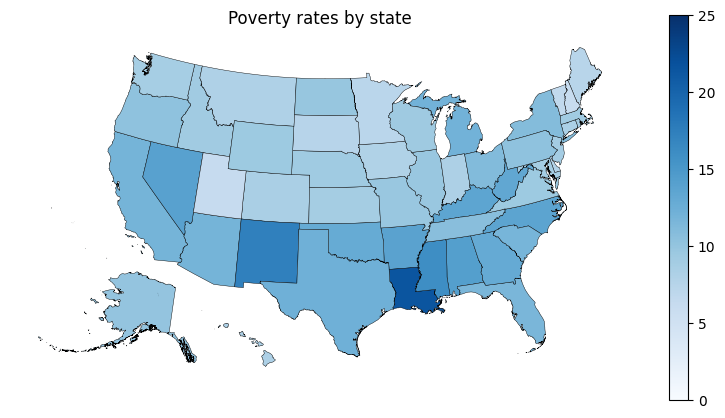

In [16]:
# plot the poverty rates
ax = cem.plot_us(
    with_geo,
    column = "poverty_rate",
    # extras
    figsize = (10, 5),
    legend = True,
    cmap = "Blues",
    vmin = 0,
    vmax = 25,
    edgecolor = "black",
    linewidth = 0.3
)

ax.axis("off")
ax.set_title("Poverty rates by state")

---
---
---